In this notebook, I will implement a few image filters.

### Import dependent packages and the dataset:

In [1]:
import numpy as np
import cv2
import time
import os

from IPython.core.display import display, Image

import torch
import torch.nn.functional as F
from torch import nn

# Enable inline plotting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Make the graphs a bit prettier, and bigger
sns.set(font_scale = 1.5)
sns.set_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':'Times new Roman'})
plt.rcParams['figure.figsize'] = (8, 6)
IMAGES_DIRECTORY = 'image/'
IMAGE_NAMES = [
    'cameramanN1.jpg',
    'cameramanN2.jpg',
    'cameramanN3.jpg',
]

C:\Users\swats\AppData\Local\Temp\ipykernel_16268\2197134503.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Image


In [2]:
# This helper functions visualizes the loaded image
def show_img(image, title=''):
    tmp_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(tmp_img)

## Image Processing

In [3]:
# Function to construct a 3x3 mean kernel
def construct_mean_kernel():
    mean_kernel = np.matrix([[1/9, 1/9, 1/9], 
                             [1/9, 1/9, 1/9],
                             [1/9, 1/9, 1/9]])
    return mean_kernel

In [4]:
construct_mean_kernel()

matrix([[0.11111111, 0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111]])

In [23]:
# Function to do convolution using for loops.
# It assumes the filter_area and kernel have the same shape
def forloop_convolution(filter_area, kernel):
    kernel_height, kernel_width = kernel.shape
    output = 0
    for i in range(kernel_height):
        for j in range(kernel_width):
            output = output + filter_area[i,j] * kernel[i,j]
    # Pixel values must be in between 0 and 255, inclusive
    if output < 0:
        return 0
    if output > 255:
        return 255
    return int(output) # Cast as int because pixel values are ints


## Mean Filter

In [6]:
def forloop_mean_filter(image):
    newimage = np.zeros((image.shape[0] - 2, image.shape[1] - 2), dtype = np.uint8)
    kernel_function = construct_mean_kernel()
    for i in range(image.shape[0] - 2):
        for j in range(image.shape[1] - 2):
            region = np.matrix([[image[0+i, 0+j], image[0+i, 1+j], image[0+i, 2+j]],
                                [image[1+i, 0+j], image[1+i, 1+j], image[1+i, 2+j]],
                                [image[2+i, 0+j], image[2+i, 1+j], image[2+i, 2+j]]])
            newimage[i][j] = forloop_convolution(region, kernel_function)
    return newimage

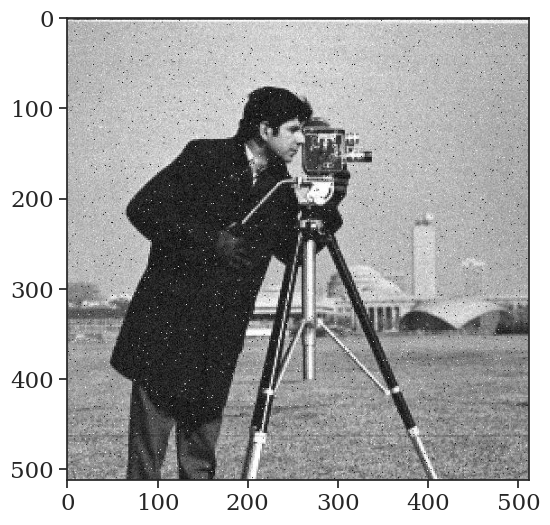

In [7]:
image_name = 'cameramanN3.jpg'
image = cv2.imread(IMAGES_DIRECTORY + image_name, 0)
show_img(image)

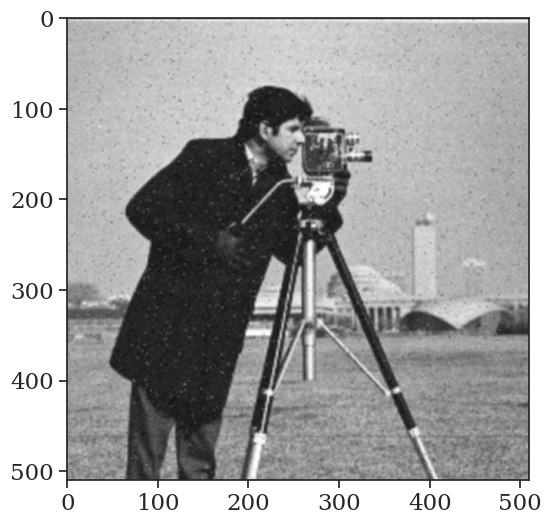

In [8]:
res = forloop_mean_filter(image)
show_img(res) # As we can see, applying the mean filter makes the image a bit blurrier, which is expected.

## Sharpening Filter

Image sharpening can be seen as convoluting the image with the following sharpening kernel:

$
(1+ALPHA)*\begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}-ALPHA
\begin{bmatrix}
1/9 &1/9 &1/9 \\
1/9 &1/9 &1/9 \\
1/9 &1/9 &1/9 \\
\end{bmatrix}
$

In [9]:
def constuct_sharping_kernel(ALPHA=0.5):
    A = (1 + ALPHA) * np.matrix([[0,0,0], [0,1,0], [0,0,0]])
    B = ALPHA * np.matrix([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
    sharp_kernel = A - B
    return sharp_kernel

In [24]:
def forloop_sharpen_filter(image):
    newimage = np.zeros((image.shape[0]-2, image.shape[1]-2), dtype=np.uint8)
    sharp_kernel = constuct_sharping_kernel(1.0)
    
    for i in range(image.shape[0] - 2):
        for j in range(image.shape[1] - 2):
            region = np.matrix([[image[0+i,0+j], image[0+i,1+j], image[0+i,2+j]],
                               [image[1+i,0+j], image[1+i,1+j], image[1+i,2+j]],
                               [image[2+i,0+j], image[2+i,1+j], image[2+i,2+j]]])
            newimage[i][j] = forloop_convolution(region, sharp_kernel)
    return newimage

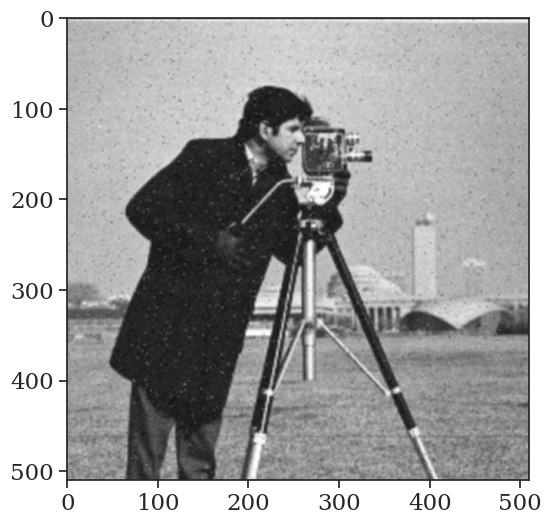

In [25]:
image_name ='cameramanN1.jpg'
image = cv2.imread(IMAGES_DIRECTORY + image_name, 0)

show_img(res)

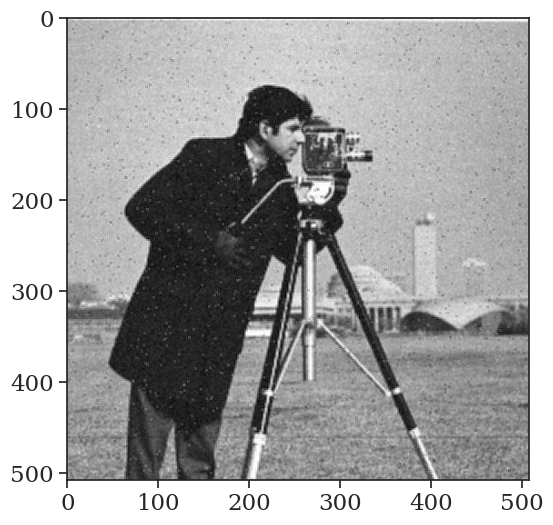

In [26]:
res2 = forloop_sharpen_filter(res)
show_img(res2)

## Image Gradient Filter
This filter computes the gradient of the images along the x and y directions.

$
fx\_kernel=\begin{bmatrix}
1 & -1 \\
1 & -1 \\
\end{bmatrix},
\quad
fy\_kernel=\begin{bmatrix}
1 & 1  \\
-1 & -1 \\
\end{bmatrix}
$

In [28]:
def constuct_fx_fy_gradient_kernel():
    # Outputs the fx and fy filters
    fx_kernel = np.matrix([[1,-1],[1,-1]])
    fy_kernel = np.matrix([[1,1],[-1,-1]])
    return fx_kernel, fy_kernel

This function will apply the fx and fy kernels to an image. Note this implementation is similar to forloop_mean_filter and forloop_sharpen_filter except the kernel size has changed from 3x3 to 2x2.

In [29]:
def forloop_image_gradient_filter(image):
    newimage_fx = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    newimage_fy = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    fx_kernel, fy_kernel = constuct_fx_fy_gradient_kernel()
    
    for i in range(image.shape[0] - 1):
        for j in range(image.shape[1] - 1):
            region = np.matrix([[image[0+i,0+j], image[0+i,1+j]],
                               [image[1+i,0+j], image[1+i,1+j]]])
            newimage_fx[i][j] = forloop_convolution(region, fx_kernel)
            newimage_fy[i][j] = forloop_convolution(region, fy_kernel)
    return newimage_fx, newimage_fy

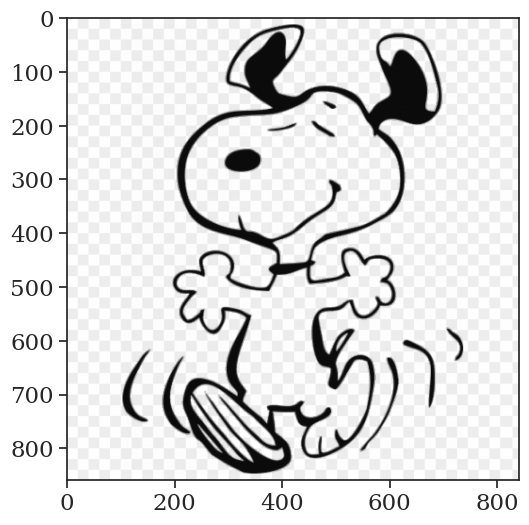

In [32]:
image_name ='snoopy.png'
image = cv2.imread(IMAGES_DIRECTORY + image_name, 0)
show_img(image)

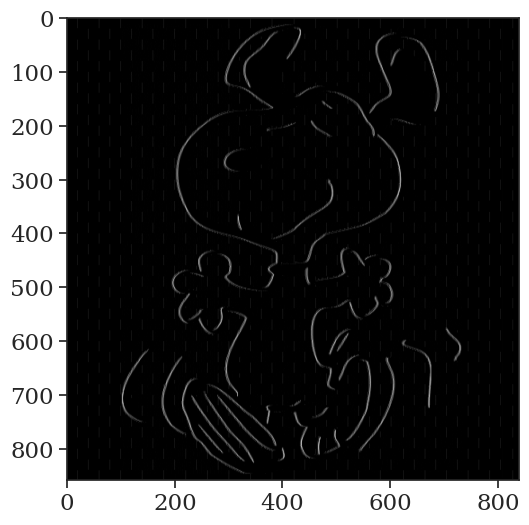

In [31]:
res_fx, res_fy = forloop_image_gradient_filter(image)
show_img(res_fx) # As we can see, the gradient filter is used for edge detection.

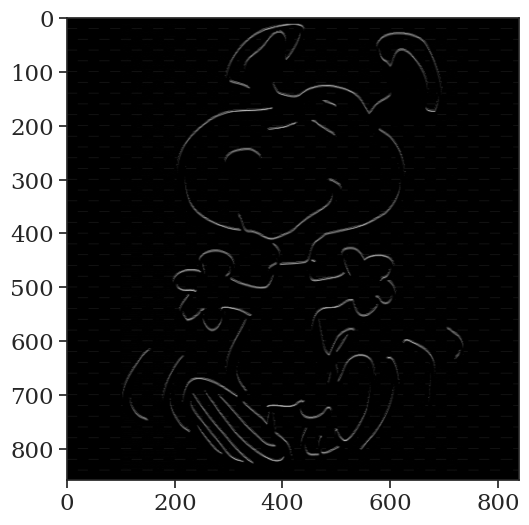

In [36]:
show_img(res_fy) 
# The difference between the gradient filter in the x (horizontal) and y (vertical) direction
# can be observed by comparing the nose and ears.

## Sobel Edge Detection

(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

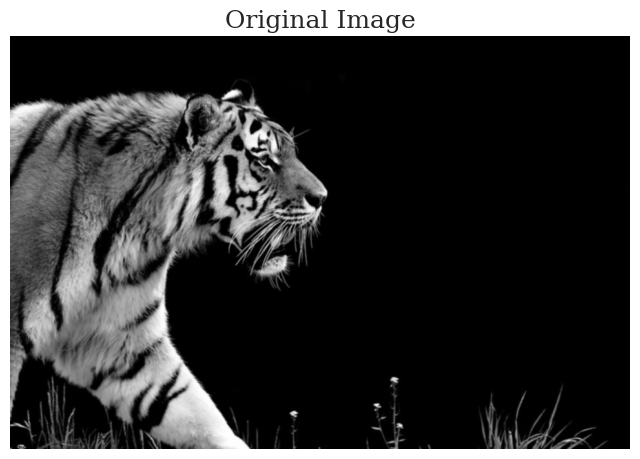

In [37]:
import requests
url = "https://cdn.pixabay.com/photo/2017/05/17/12/42/tiger-2320819_960_720.jpg"

r = requests.get(url)
with open('image/tiger.jpg', 'wb') as f:
    f.write(r.content) 

img = cv2.imread('image/tiger.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(gray,(3,3),0)
plt.imshow(img, cmap='gray')
plt.title('Original Image') 
plt.axis("off")

In the image gradient filter, a rudimental edge detector is implemented. In practice, there are more sophisticated edge detectors. For example, the sobel edge detector finds the largest increase in intensity from light to dark and emphasises on those pixels giving an edge enhanced image.

In this example, the Sobel detection is explored by calling existing libraries.

Syntax: 
```python
dst = cv2.Sobel(src, ddepth, dx, dy, ksize)
```
- `ddepth` is the depth of the destination image, 
- `dx` is Horizontal sobel derivative, 
- `dy` is vertical sobel derivative,
- `ksize` is the kernel size.


Set `ddepth=cv2.CV_64F` and `ksize=5` in the function `cv2.Sobel` and then set appropriate values for the `src, dx, dy`. (dx and dy should be set to 1 or 0.).



In [38]:
def Horizontal_sobel_derivative(image):
    sobelx = cv2.Sobel(image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
    return sobelx

(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

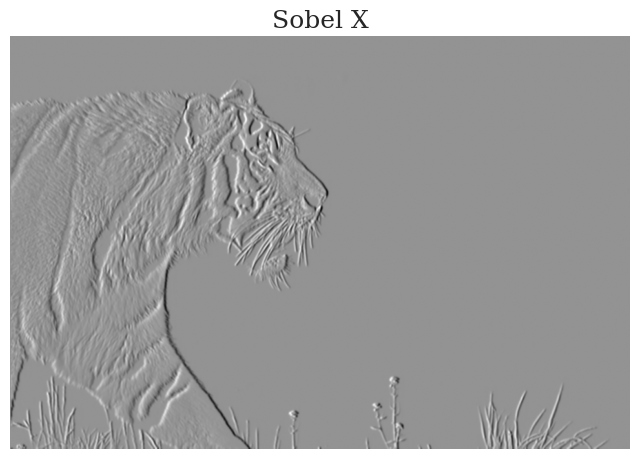

In [39]:
sobelx= Horizontal_sobel_derivative(img)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.axis("off")

(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

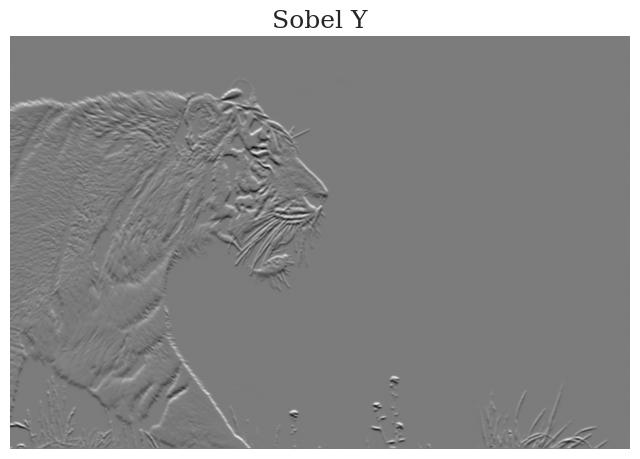

In [41]:
sobely = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)

plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y') 
plt.axis("off")

(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

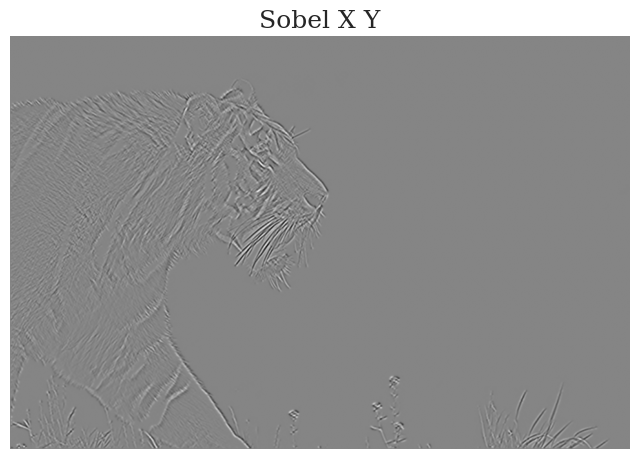

In [40]:
sobelxy = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

plt.imshow(sobelxy, cmap='gray')
plt.title('Sobel X Y') 
plt.axis("off")